<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Импортируем необходиме для работы библиотеки

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings("ignore")

Откроем наш датасет и изучим информацию по нему

In [2]:
taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
taxi.sort_index(inplace=True)
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Выполним ресемплирование по одному часу и посмотрим как это выглядит

<AxesSubplot:xlabel='datetime'>

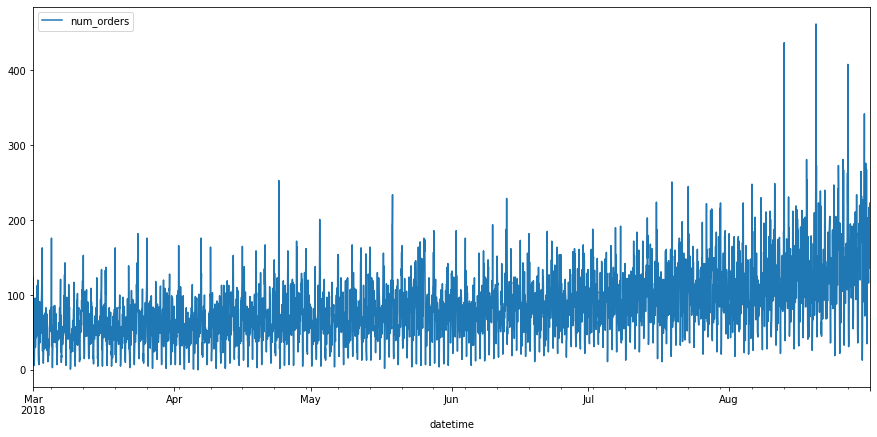

In [4]:
taxi.sort_index(inplace=True)
taxi = taxi.resample('1H').sum()
figsize = (15,7)
taxi.plot(figsize=figsize)

Мы модем сделать вывод, что ближе к учебному году спрос на такси увеличивается, околонулевых значений становится меньше, спрос на такси в выходные дни зашкаливает. В последние жаркие деньки лета хочется и отдохнуть, и к учебному году успеть приготовиться

## Анализ

Рассмотрим наши данные с разных сторон

Построим графики за последний месяц

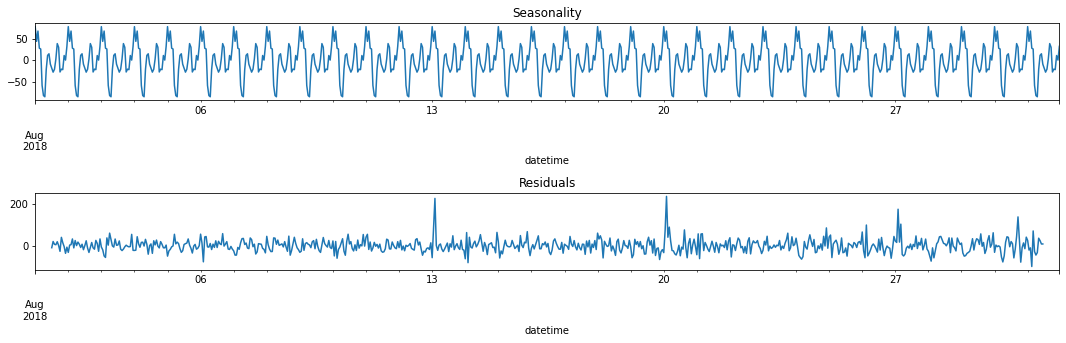

In [5]:
decomposed = seasonal_decompose(taxi['2018-08-01':'2018-08-31'])
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), figsize=figsize)# < напишите код здесь >
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), figsize=figsize)# < напишите код здесь >
plt.title('Residuals')
plt.tight_layout()

По графикам за последний месяц конечно же видно динамику роста заказа такси к концу рассматриваемого последнего месяца. Также видно, что в течении дня наблюдается рост потребности населения в такси, к вечеру достигает пика и к утру следующего дня сходит к минимальным значениям. 

Мы не можем сказать, что временной ряд является стационарным, так как у него меняется среднее значение

Создадим признаки для обучения модели

In [6]:
taxi = taxi.resample('1H').sum()

def make_features(taxi, max_lag, rolling_mean_size):
    taxi['hour'] = taxi.index.hour
    taxi['dayofweek'] = taxi.index.dayofweek
    for lag in range(1, max_lag + 1):
        taxi['lag_{}'.format(lag)] = taxi['num_orders'].shift(lag)
    taxi['rolling_mean'] = taxi['num_orders'].shift().rolling(rolling_mean_size).mean()   
    return taxi

In [7]:
make_features(taxi, 2, 23)
print(taxi.head(24))

                     num_orders  hour  dayofweek  lag_1  lag_2  rolling_mean
datetime                                                                    
2018-03-01 00:00:00         124     0          3    NaN    NaN           NaN
2018-03-01 01:00:00          85     1          3  124.0    NaN           NaN
2018-03-01 02:00:00          71     2          3   85.0  124.0           NaN
2018-03-01 03:00:00          66     3          3   71.0   85.0           NaN
2018-03-01 04:00:00          43     4          3   66.0   71.0           NaN
2018-03-01 05:00:00           6     5          3   43.0   66.0           NaN
2018-03-01 06:00:00          12     6          3    6.0   43.0           NaN
2018-03-01 07:00:00          15     7          3   12.0    6.0           NaN
2018-03-01 08:00:00          34     8          3   15.0   12.0           NaN
2018-03-01 09:00:00          69     9          3   34.0   15.0           NaN
2018-03-01 10:00:00          64    10          3   69.0   34.0           NaN

Разобьем наши данные на тренировочную и тестовые выборки. Так как нам нужно обучить модель предсказывать на час, возьмем период с середины июля по конец августа

In [8]:
taxi_new = taxi['2018-07-16':'2018-08-31']
taxi_new

,num_orders,hour,dayofweek,lag_1,lag_2,rolling_mean
datetime,,,,,,
2018-07-16 00:00:00,224,0,0,100.0,98.0,89.173913
2018-07-16 01:00:00,109,1,0,224.0,100.0,95.608696
2018-07-16 02:00:00,126,2,0,109.0,224.0,94.782609
2018-07-16 03:00:00,136,3,0,126.0,109.0,96.739130
2018-07-16 04:00:00,187,4,0,136.0,126.0,98.478261
...,...,...,...,...,...,...
2018-08-31 19:00:00,136,19,4,207.0,217.0,168.913043
2018-08-31 20:00:00,154,20,4,136.0,207.0,168.652174
2018-08-31 21:00:00,159,21,4,154.0,136.0,166.739130


In [9]:
train, test = train_test_split(taxi_new, shuffle=False, test_size=0.1)
train = train.dropna()

In [10]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']
print('Обучающая выборка:', features_train.shape)
print(target_train.shape)
print('Тестовая выборка:', features_test.shape)
print(target_test.shape)

Обучающая выборка: (1015, 5)
(1015,)
Тестовая выборка: (113, 5)
(113,)


**Вывод**

Данные были проанализированы и подготовленны к обучению

## Обучение

Обучение будем производить применяя различные модели. Начнем с модели **Дерево решений**

In [11]:
%%time
dt = DecisionTreeRegressor()
max_depth_parameters = [i for i in range(1,30)]
hyperparams = [{'criterion':['mse'],
               'max_depth':max_depth_parameters,
               'random_state':[12345]}]

CPU times: user 29 µs, sys: 6 µs, total: 35 µs
Wall time: 37.9 µs


In [12]:
%%time
tscv = TimeSeriesSplit(n_splits=8) # в документации написано количество расколов, я так понимаю это сколько часетй стало от начального датасета?
dt_grid = GridSearchCV(dt, param_grid=hyperparams, scoring='neg_mean_squared_error') 
dt_grid.fit(features_train, target_train)

CPU times: user 911 ms, sys: 3.87 ms, total: 915 ms
Wall time: 936 ms


GridSearchCV(estimator=DecisionTreeRegressor(),
             param_grid=[{'criterion': ['mse'],
                          'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                        13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                        23, 24, 25, 26, 27, 28, 29],
                          'random_state': [12345]}],
             scoring='neg_mean_squared_error')

In [13]:
dt_grid.best_params_

{'criterion': 'mse', 'max_depth': 3, 'random_state': 12345}

Далее обучим модель **LGBMRegressor**

In [14]:
%%time
lgbm = LGBMRegressor()
hyperparams = [{'learning_rate':[x/10 for x in range(1, 6)],
                'random_state':[12345]}]

CPU times: user 25 µs, sys: 4 µs, total: 29 µs
Wall time: 32.7 µs


In [15]:
%%time
lgbm_grid = GridSearchCV(lgbm, hyperparams, scoring='neg_mean_squared_error')
lgbm_grid.fit(features_train, target_train)

CPU times: user 15.9 s, sys: 177 ms, total: 16.1 s
Wall time: 16.2 s


GridSearchCV(estimator=LGBMRegressor(),
             param_grid=[{'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
                          'random_state': [12345]}],
             scoring='neg_mean_squared_error')

In [16]:
lgbm_grid.best_params_

{'learning_rate': 0.1, 'random_state': 12345}

**Вывод**

Добавили признаков для обучения моделей, разбили наш датаест на тренировочную и тестовую выборки, подобрали гиперпараметры и обучили 2 модели, готовы к предсказаниям

## Тестирование

Первой протестируем метод Дерево решений

In [17]:
predictions_dt_grid = dt_grid.predict(features_test)
result = (mean_squared_error(target_test, predictions_dt_grid))**0.5
print('RMSE DecisionTreeRegressor:', result)

RMSE DecisionTreeRegressor: 52.81354409525127


Text(0.5, 1.0, 'Результат модели, 2 дня')

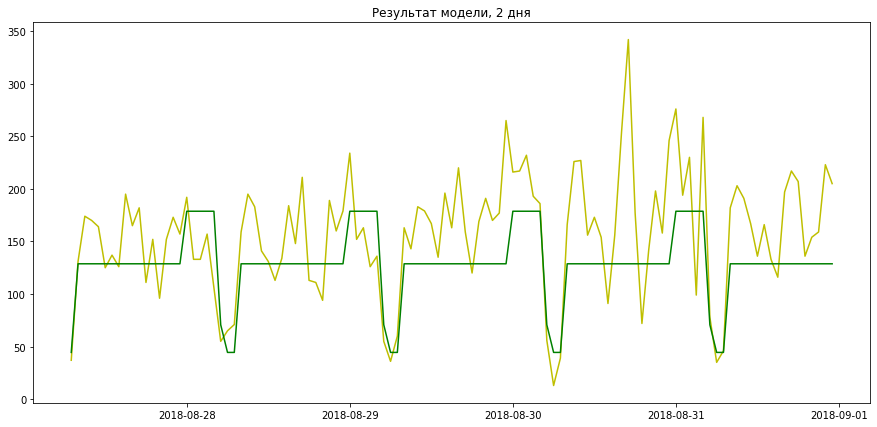

In [18]:
plt.figure(figsize=figsize)
plt.plot(target_test.index,
        target_test,
        'y-',
        target_test.index,
        predictions_dt_grid,
        'g-')
plt.title('Результат модели, 2 дня')

Как мы можем видеть из графика модель не очень хорошо справилась со своей задачей. RMSE 52.81  это не очень хороший результат! 

Далее LGBMRegressor

In [19]:
predictions_lgbm_grid = lgbm_grid.predict(features_test)
print(f'RMSE LGBMRegressor: {mean_squared_error(target_test, predictions_lgbm_grid, squared=False)}')

RMSE LGBMRegressor: 44.93718714751378


Text(0.5, 1.0, "Text(0.5, 1.0, 'Результат модели, 2 дня')")

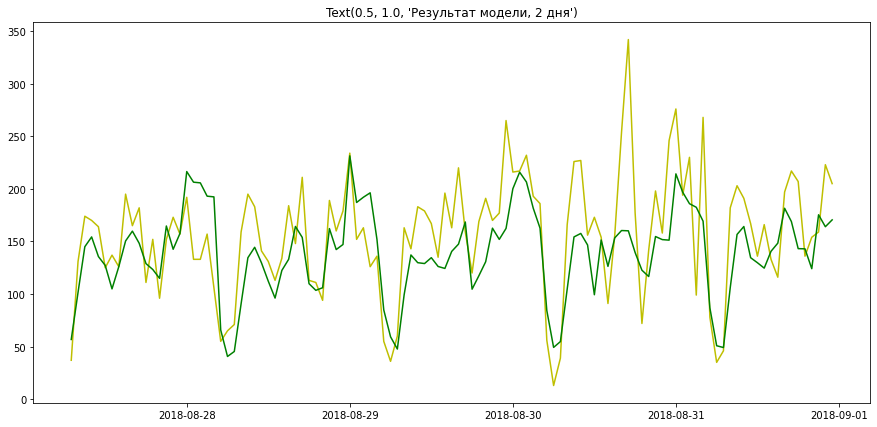

In [20]:
plt.figure(figsize=figsize)
plt.plot(target_test.index,
        target_test,
        'y-',
        target_test.index,
        predictions_lgbm_grid,
        'g-')
plt.title(plt.title('Результат модели, 2 дня'))

Модель LGBMRegressor гораздо лучше справилось с поставленной задачей. Как мы видим из графика модель больше усреднила значения и не подвержена выбросам. 